In [179]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Abstract

This blog post explores the perceptron algorithm. I implement the algorithm in python, then test my implementation over different sets of data. I test the algorithm over data that is linearly separable and data that is not, and data of different dimensions. I also implemented a minibatch perceptron algorithm that considers multiple points each iteration. I tested this implementation over different batch sizes using different sets of data. 

## Part A: Implementing Perceptron

Link to perceptron source code: https://github.com/tristanmeyer2/tristanmeyer2.github.io/blob/main/posts/ImplementingPerceptron/perceptron.py

Link to minibatch perceptron source code: https://github.com/tristanmeyer2/tristanmeyer2.github.io/blob/main/posts/ImplementingPerceptron/minibatchperceptron.py

Here is my implementation for the grad() function:

```
def grad(self, X, y):
    s_i = self.score(X) 
    return torch.where(y*s_i < 0, y@X, 0.0)
```
The function calculates the score using matrix multiplication with the models weight vector, then returns a tensor in which if the score multiplied by the y is less than 0, the value is y matrix multiplied by X, and if it is greater than 0, the value is zero. 

## Checking Implementation

In [180]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(1234)

def perceptron_data(n_points, noise, p_dims):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1
    y = y.type(torch.FloatTensor)

    return X, y

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")
    
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)


Creating a perceptron_data function, which generates data over two quantitative variables and a qualitative feature. Creating a plot_perceptron_data function which visualizes the data created by the perceptron_data function. Creating a draw_line function which visualizes a line on a plot.  

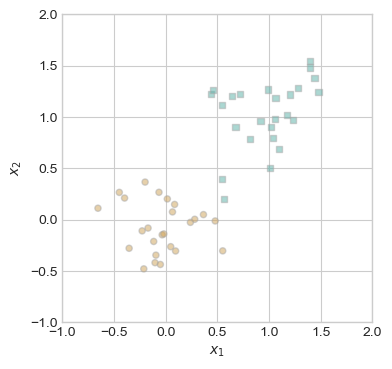

In [181]:
torch.manual_seed(1234)
X, y = perceptron_data(n_points = 50, noise = 0.3, p_dims = 2)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)

The perceptron data is split into an X feature matrix and a y target vector. The plot shows the linearly separable perceptron data. 

In [182]:
torch.manual_seed(1234)

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

The perceptron algorithm is run in a minimal training loop that calls the loss function and the step function until there is zero loss (no misclassifications).

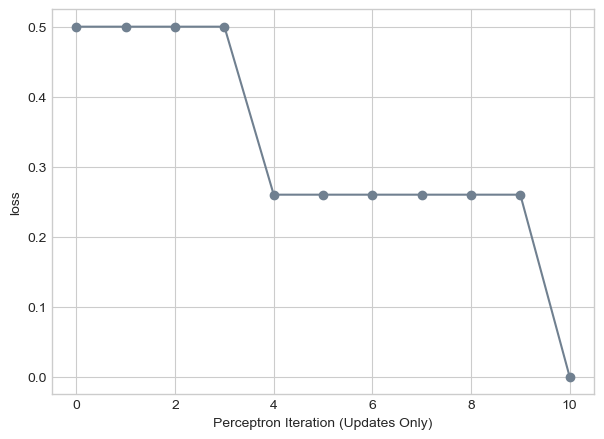

In [183]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

This plot shows the loss over several iterations of the perceptron algorithm. As shown, the loss decreases until it reaches a value of zero. 

## Part B: Experiments

## Using 2D linearly separable data:

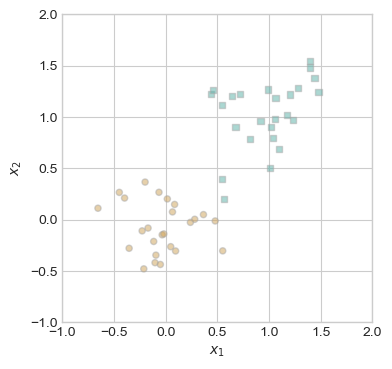

In [184]:
torch.manual_seed(1234)
X, y = perceptron_data(n_points = 50, noise = 0.3, p_dims = 2)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)

Generating and visualization linearly separable data. 

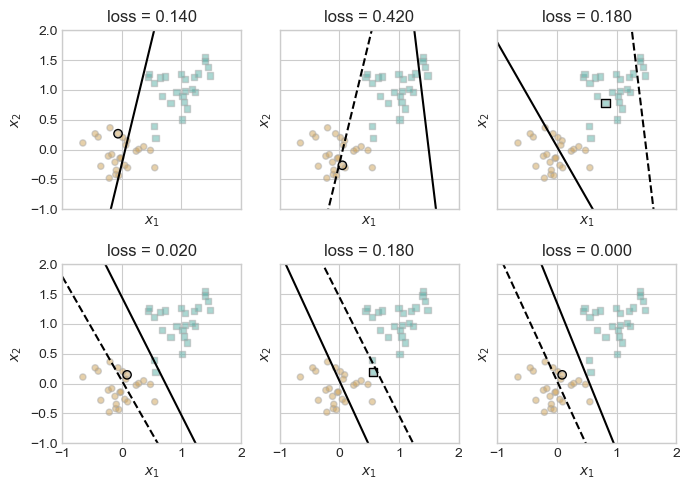

In [185]:
torch.manual_seed(1234567)
# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5) 
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []
maxIterations = 1000
currIteration = 0

while loss > 0 and currIteration < maxIterations:
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 
    randomPoint = torch.randint(X.shape[0], size = (1,))
    X_i = X[[randomPoint],:]
    y_i = y[randomPoint]
    local_loss = opt.step(X_i, y_i)

    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if local_loss > 0:
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[randomPoint,0],X[randomPoint,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[y[randomPoint].item()]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1
    currIteration += 1
plt.tight_layout()

The perceptron algorithm is run on a training loop that terminates after 1000 iterations. The changes in the loss value are visualized on the plot, showing the previous estimate of a separating line (shown by the dashed line), and the change that the perceptron optimizer made to the separating line (shown by the solid line). The plot shows the final iteration, which resulted in a separating line with zero loss.  

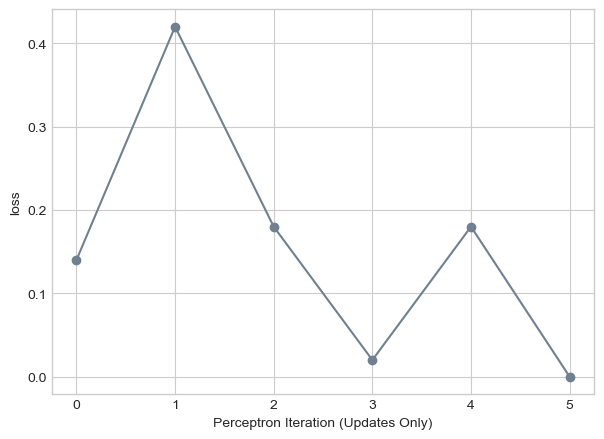

In [186]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

This plot shows the changes in the loss over different iterations of the perceptron algorithm. 

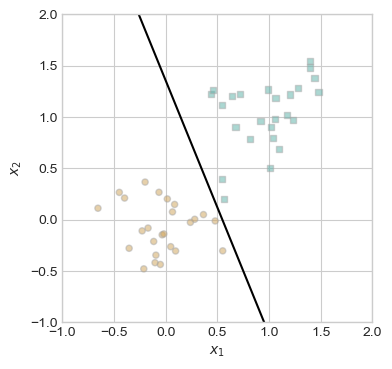

In [187]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)
draw_line(p.w, -1, 2, ax, color = "black")

This plot shows the final iteration of the perceptron algorithm, which resulted in a loss of zero. As shown, the line perfectly separates the data. 

## Using 2D non-linearly separable data:

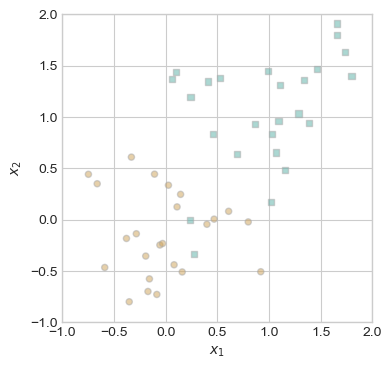

In [188]:
torch.manual_seed(1234)
X, y = perceptron_data(n_points = 50, noise = 0.5, p_dims = 2)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)

The data shown above is not linearly separable. 

In [189]:
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]
maxIterations = 1000
currIteration = 0

while loss > 0 and currIteration < maxIterations: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)
    currIteration += 1

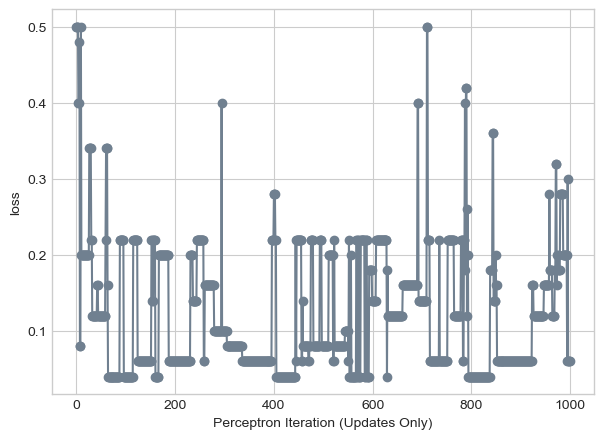

In [190]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

Over a thousand iterations, the perceptron algorithm never results in a loss of zero because the data is not linearly separable. However, the algorithm did result in a loss of under 0.1. 

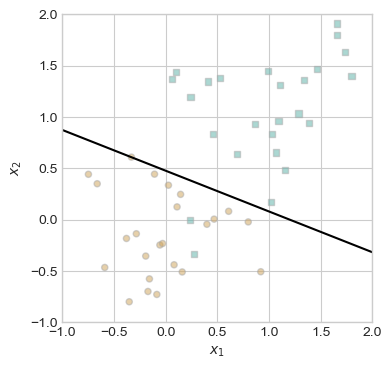

In [191]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)
draw_line(p.w, -1, 2, ax, color = "black")

The separating line above appears to effectively separate the dataset while minimizing the loss (there are only a few points that are misclassified). 

## Using 5D linearly separable data:

In [192]:
torch.manual_seed(1234)
X, y = perceptron_data(n_points = 50, noise = 0.1, p_dims = 5)

Generating data over five dimensions. 

In [193]:
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]
maxIterations = 1000
currIteration = 0

while loss > 0 and currIteration < maxIterations: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)
    currIteration += 1

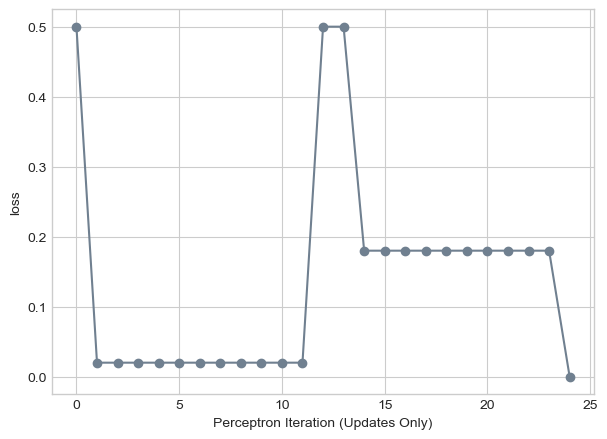

In [194]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

As shown by the graph of the loss vector, the algorithm reaches a loss of zero in under 25 iterations, even with five dimensional data. 

## Part C: Minibatch Perceptron

In [195]:
from minibatchperceptron import MiniBatchPerceptron, MiniBatchPerceptronOptimizer

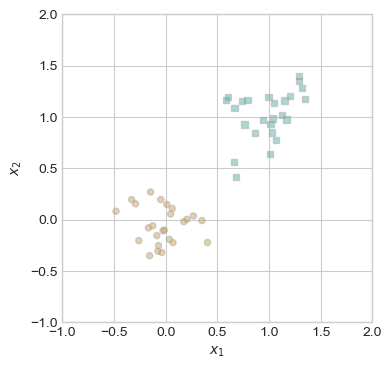

In [196]:
torch.manual_seed(1234)
X, y = perceptron_data(n_points = 50, noise = 0.22, p_dims = 2)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)

Generating two dimensional linearly separable data. 

In [197]:
def training_loop(k, a, p, opt):
    
    loss = 1.0

    # for keeping track of loss values
    loss_vec = []

    n = X.size()[0]
    maxIterations = 10000
    currIteration = 0
    loss = p.loss(X, y) 
    loss_vec.append(loss)


    while loss > 0 and currIteration < maxIterations: 
        
        # not part of the update: just for tracking our progress    
        loss = p.loss(X, y) 
        loss_vec.append(loss)
        
        # pick a random group of data points
        ix = torch.randperm(X.size(0))[:k]
        x_ix = X[ix,:]
        y_ix = y[ix]
        
        # perform a perceptron update using the random data point
        opt.step(x_ix, y_ix, a, k)
        currIteration += 1
    return loss_vec

Defining a new training loop for the minibatch perceptron algorithm. 

In [198]:
p = MiniBatchPerceptron() 
opt = MiniBatchPerceptronOptimizer(p)
loss_vec = training_loop(1,1, p, opt)

Testing the minibatch algorithm with a batch size of 1 and alpha of 1. 

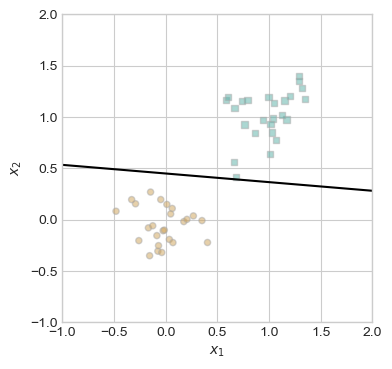

In [199]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)
draw_line(p.w, -1, 2, ax, color = "black")

This chart shows the separating line produced by this algorithm.

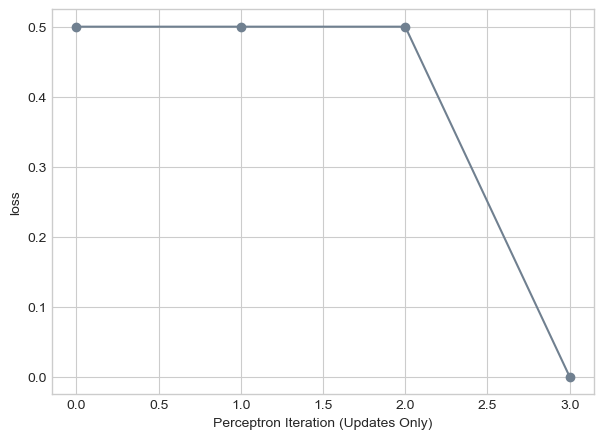

In [200]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

As shown by the chart of the loss vector, the algorithm reached a loss of zero in three iterations.

In [201]:
p = MiniBatchPerceptron() 
opt = MiniBatchPerceptronOptimizer(p)
loss_vec = training_loop(10,3, p, opt)

Testing the minibatch algorithm with a batch size of 10 and alpha of 3. 

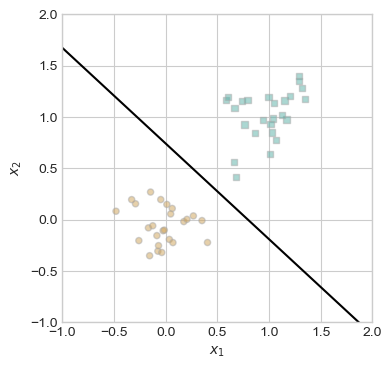

In [202]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)
draw_line(p.w, -1, 2, ax, color = "black")

This chart shows the separating line produced by this algorithm.

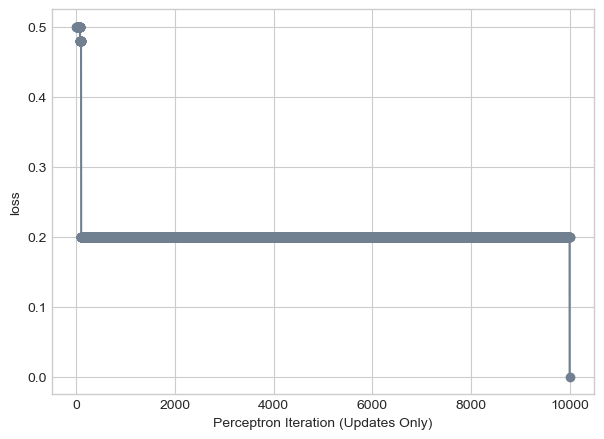

In [203]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

As shown by the chart of the loss vector, the algorithm reached a loss of zero in around 10,000 iterations.

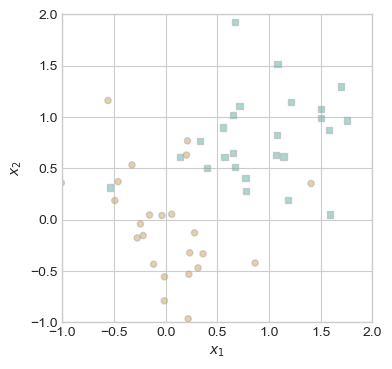

In [204]:
torch.manual_seed(1235)
X, y = perceptron_data(n_points = 50, noise = 0.5, p_dims = 2)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)

Generating non-linearly separable data over two dimensions.

In [205]:
p = MiniBatchPerceptron() 
opt = MiniBatchPerceptronOptimizer(p)
loss_vec = training_loop(50,0.01, p, opt)

Testing the minibatch algorithm with a batch size equal to the number of points and alpha of 0.01. 

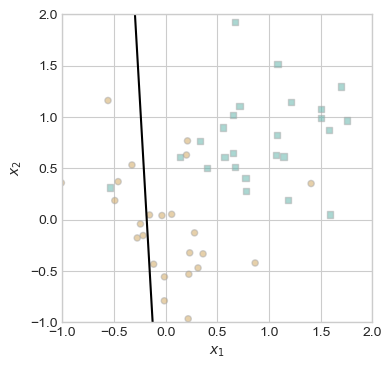

In [206]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)
draw_line(p.w, -1, 2, ax, color = "black")

Due to the large batch size, the algorithm does not perform perfectly. The line separating the data does not minimize the loss. 

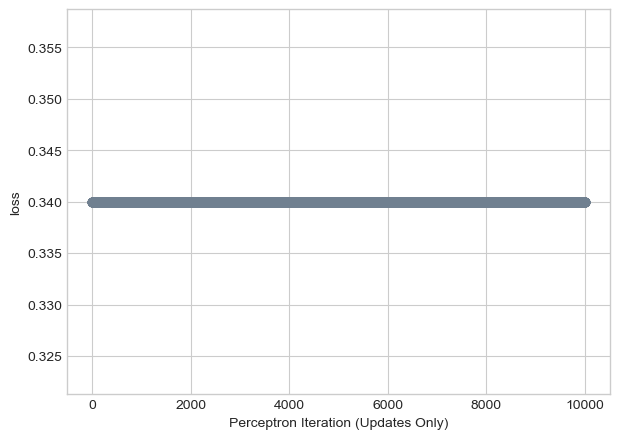

In [207]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

This charts shows the loss over 10,000 iterations of the algorithm. 

## Runtime Analysis

The runtime of a single iteration of the perceptron algorithm with n points and p features is O(p). The runtime is O(p) because for each iteration, the algorithm checks the misclassification of a single data point over p features using matrix multiplication, therefore if the number of features increases, the algorithm has to do more computation. 

The runtime of a single iteration of the mini batch algorithm with n points, p features, and a batch size of b is O(p * b). The runtime is O(p * b) because this runtime can be thought of as doing the regular perceptron grad function b times, therefore as the batch size increases, the algorithm needs to do more computation. 

## Conclusion

I implemented the perceptron and minibatch perceptron in this blog post. I explored each algorithm with different data sets with different dimensions. This post was great practice working with matrix multiplication and assuring the dimensions of my matrices were correct. This post was also good practice working with training loops and displaying the results from my tests. 